<a href="https://colab.research.google.com/github/Otobi1/Back-to-Basics-A-Refresher-/blob/master/Back_to_Basics_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Logistic Regression 
# - in this lesson, we will implement a logistic regression for a classification task.
# - we will probabilistically determine the outcome for a given set of inputs by understanding te math and implementing both in NumPy and PyTorch

In [3]:
# Losgistic Regressio is an extension of linear regression (both are generalised linear methods)
# We can still learn to model a line (plane) that models y given X.
# - Except now, we are dealing with classification problems as opposed to regression problems so we'll be predicting probability distributions as opposed to discrete values.
# - We will use the softmax operation to normalise our logits (XW) to derive the probabilities

# - We will leave the bias weights out for now to avoid complicating the backpropagation

In [4]:
# Objective - Predict the probability of class y given inputs X. The softmax classifier normalises the linear outputs to determine class probabilities
# Advantages - Can predict class probabilities given a aset of inputs
# Disadvantages  Sensitive to outliers since the obj., is to minimise cross entropy loss. SVMs are better.
# Softmax classifier is used widely in neural network architectiers as the last layer since it produces class probabilities

In [5]:
## Set Up

# Importing the necessary libraries 

import numpy as np
import random

In [6]:
SEED = 1234

In [7]:
# Set seed for reproducibility 

np.random.seed(SEED)
random.seed(SEED)

In [9]:
# Load data 
# - We'll use some synthesised data (no clinical relevance). 
# - the task is to determine whether a tumor will be benign (harmless) or malignant(harmful) based on leukocyte (white blood cells) count and blood pressure. 

In [10]:
# More libraries 

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [11]:
np.random.seed(SEED)

In [12]:
# Reading the data from csv to pandas dataframe

url = "https://raw.githubusercontent.com/GokuMohandas/madewithml/main/datasets/tumors.csv"
df = pd.read_csv(url, header = 0) # load
df = df.sample(frac = 1).reset_index(drop = True) # Shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [14]:
# Defining the inputs X and output y

X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values

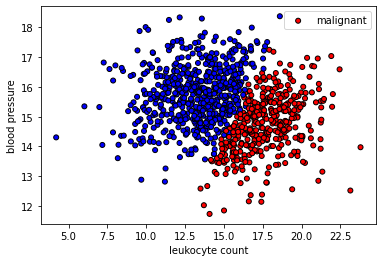

In [16]:
# Plot data

colours = {"benign": "red", "malignant": "blue"} 
plt.scatter(X[:,0], X[:,1], c = [colours[_y] for _y in y], s = 25, edgecolors = "k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc = "upper right")
plt.show()

In [17]:
# Splitting the data

# - we need to split the data such that the three splits have the same distribution of classes to ensure proper training and evaluation

# - using sklearn 

import collections
from sklearn.model_selection import train_test_split

In [18]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15 
TEST_SIZE = 0.15

In [20]:
def train_val_test_split(X, y, train_size):
  """Split dataset into data splits."""
  X_train, X_, y_train, y_ = train_test_split(X, y, train_size = TRAIN_SIZE, stratify = y)
  X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size = 0.5, stratify = y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [21]:
# Creating data splits

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X = X, y = y, train_size = TRAIN_SIZE)

print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} -> {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] -> malignant


In [23]:
# Now lets check the number of samples per class within each data split 

# Overall class distribution 

class_counts = dict(collections.Counter(y))
print (f"Classes: {class_counts}")
print (f"m:b = {class_counts['malignant']/class_counts['benign']:.2f}")

Classes: {'benign': 389, 'malignant': 611}
m:b = 1.57


In [24]:
# Per data split class distribution 

train_class_counts = dict(collections.Counter(y_train))
val_class_counts = dict(collections.Counter(y_val))
test_class_counts = dict(collections.Counter(y_test))

print (f"train m:b = {train_class_counts['malignant']/train_class_counts['benign']:.2f}")
print (f"val m:b = {val_class_counts['malignant']/val_class_counts['benign']:.2f}")
print (f"test m:b = {test_class_counts['malignant']/test_class_counts['benign']:.2f}")

train m:b = 1.57
val m:b = 1.54
test m:b = 1.59


In [25]:
# Label Encoding 
# - Notice our class labels are text, we need to encode them into integers so we can use them in our model
# - We can use the sklearn's LabelEncoder to do this, but we will write our own simple label encoder class to see what is going on under the hood.


In [26]:
import itertools

In [27]:
class LabelEncoder(object):
  """Label encoder for tag labels."""
  
  def __init__(self, class_to_index = {}):
    self.class_to_index = class_to_index
    self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    self.classes = list(self.class_to_index.keys())

  def __len__(self):
    return len(self.class_to_index)
  
  def __str__(self):
    return f"<LabelEncoder(num_classes = {len(self)})>"
  
  def fit(self, y):
    classes = np.unique(y_train)
    for i, class_ in enumerate(classes):
      self.class_to_index[class_] = i
    self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    self.classes = list(self.class_to_index.keys())
    return self
  
  def encode(self, y):
    encoded = np.zeros((len(y)), dtype = int)
    for i, item in enumerate(y):
      encoded[i] = self.class_to_index[item]
    return encoded

  def decode(self, y):
    classes = []
    for i, item in enumerate(y):
      classes.append(self.index_to_class[item])
    return classes

  def save(self, fp):
    with open(fp, 'w') as  fp:
      contents = {"class_to_index": self.class_to_index}
      json.dump(contents, fp, indent = 4, sort_keys = False)

  @classmethod
  def load(cls, fp):
    with open(fp, 'r') as fp:
      kwargs = json.load(fp = fp)
    return cls(**kwargs)

    

In [28]:
# Fit 

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'benign': 0, 'malignant': 1}

In [29]:
# Encoder 
print(f"y_train[0]: {y_train[0]}")

y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)

print(f"y_train[0]: {y_train[0]}")
print(f"decoded: {label_encoder.decode([y_train[0]])}")

y_train[0]: malignant
y_train[0]: 1
decoded: ['malignant']


In [30]:
# We also want to calculate the class weights, which are useful fro weighting the loss function during training. 
# it tells the models to focus on samples from an under-represented class
# the loss section below will show how to incorporate these weights


In [54]:
# Class weights 

counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


In [55]:
# Standardise data 
# - we need to standardise our data (zero mean and unit variance) so a specific features magnitude does not affect how the model learns its weights.
# - we are only going to standardise the inputs X because our outputs y are class values.

from sklearn.preprocessing import StandardScaler

In [56]:
# Standardise the data (mean = 0, std = 1) using the traing data

X_scaler = StandardScaler().fit(X_train)

In [58]:
# Apply scaler on training and test data (dont standardise the outputs)

X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [68]:
# Check (mean should be  approx 0 and std approx 1)

print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis = 0):.1f}, std: {np.std(X_test[:, 0], axis = 0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis = 0):.1f}, std: {np.std(X_test[:, 1], axis = 0):.1f}")

X_test[0]: mean: 14.8, std: 3.0
X_test[1]: mean: 15.3, std: 1.1


In [38]:
## NumPy Implementation 

# - implementing using NumPy facilitates an understanding of the underlying operations

In [60]:
# #Step 1 - Randomly initialise the model's weights W 

INPUT_DIM = X_train.shape[1] # X is 2 - dimensional
NUM_CLASSES = len(label_encoder.classes) # y has to possibilities (benign or malignant)

In [61]:
# Initialise random weights 

W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))

print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


In [41]:
## Model 
# Step 2 - Feed inputs X into the model to receive the logits (z = XW)
# Apply the softmax operation on the logits to get the class probabilities y in one-hot encoded form. 

In [69]:
# Forward pass [NX2] * [2X2] + [1,2] = [NX2]
logits = np.dot(X_train, W) + b

print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (700, 2)
sample: [ 0.17512393 -0.08002469]


In [70]:
# Normalisation via softmax to obtain class probabilities 

exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis = 1, keepdims = True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (700, 2)
sample: [0.56344334 0.43655666]


In [72]:
## Loss 
# Step 3 - Compare the predictions y hat with the actual target values y with the objective (cost) function to determine the loss
# A common objective function for the logistic regression is cross entropy loss

# Loss 

correct_class_logprobs = - np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")

loss: 0.71


In [46]:
## Gradient 
# Calculate the gradient of loss J w.r.t the model weights.
# - Lets assume our classes are mutually exclusive (can only belong to one class)

In [73]:
# Backpropagation 
dscores = y_hat
dscores[range(len(y_hat)), y_train] -=1
dscores /=len(y_train)
dW = np.dot(X_train.T, dscores)
db = np.sum(dscores, axis = 0, keepdims = True)

In [74]:
## Update weights 
# Step 5 - Update weights W using a small learnign rate. 
# - the updates will penalise the probability for the incorrect classes and encourage a higher probability for the correct class 

LEARNING_RATE = 1e-1

In [75]:
# Update weights 

W += - LEARNING_RATE * dW
b += - LEARNING_RATE * db

In [76]:
# Training 
# Step 6 - Repeat steps 2 - 5 to minimise the loss and train the model

NUM_EPOCHS = 50

In [77]:
# Initialise random weights 

W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))

In [80]:
# Training loop

for epoch_num in range (NUM_EPOCHS):

  # Forward pass [NX2] * [2X2] + [1,2] = [NX2]
  logits = np.dot(X_train, W) + b

  # Normalisation via softmax to obtain class probabilities 
  exp_logits = np.exp(logits)
  y_hat = exp_logits / np.sum(exp_logits, axis = 1, keepdims = True)

  # Loss
  correct_class_logprobs = - np.log(y_hat[range(len(y_hat)), y_train])
  loss = np.sum(correct_class_logprobs) / len(y_train)

  # Show progress 
  if epoch_num%5 == 0:
    # Accuracy
    y_pred = np.argmax(logits, axis = 1)
    accuracy = np.mean(np.equal(y_train, y_pred))
    print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

  # Backpropagation
  dscores = y_hat
  dscores[range(len(y_hat)), y_train] -=1
  dscores /=len(y_train)
  dW = np.dot(X_train.T, dscores)
  db = np.sum(dscores, axis = 0, keepdims = True)

  # Update weights
  W += - LEARNING_RATE * dW
  b += - LEARNING_RATE * db


Epoch: 0, loss: 0.035, accuracy: 0.986
Epoch: 5, loss: 0.035, accuracy: 0.986
Epoch: 10, loss: 0.035, accuracy: 0.986
Epoch: 15, loss: 0.035, accuracy: 0.986
Epoch: 20, loss: 0.035, accuracy: 0.986
Epoch: 25, loss: 0.035, accuracy: 0.986
Epoch: 30, loss: 0.035, accuracy: 0.986
Epoch: 35, loss: 0.035, accuracy: 0.986
Epoch: 40, loss: 0.035, accuracy: 0.986
Epoch: 45, loss: 0.035, accuracy: 0.986


In [81]:
# Evaluation 

class LogisticRegressionFromScratch():
  def predict(self,x):
    logits = np.dot(x, W) + b
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis = 1, keepdims = True)
    return y_hat

In [82]:
# Evaluation 

model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis = 1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis = 1)

In [83]:
# Training and test accuracy 

train_acc = np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.99, test acc: 0.99


In [97]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp = None):
  """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
  # Axis boundary 
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                       np.linspace(y_min, y_max, 101))
    
  # Create predictions 
  x_in = np.c_[xx.ravel(), yy.ravel()]
  y_pred = model.predict(x_in)
  y_pred = np.argmax(y_pred, axis = 1).reshape(xx.shape)

  # Plot decision boundary 
  plt.contourf(xx, yy, y_pred, cmap = plt.cm.Spectral, alpha = 0.8)
  plt.scatter(X[:, 0], X[:, 1], c = y, s = 40, cmap = plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

  # plot 
  if savefig_fp:
    plt.savefig(savefig_fp, format = "png")

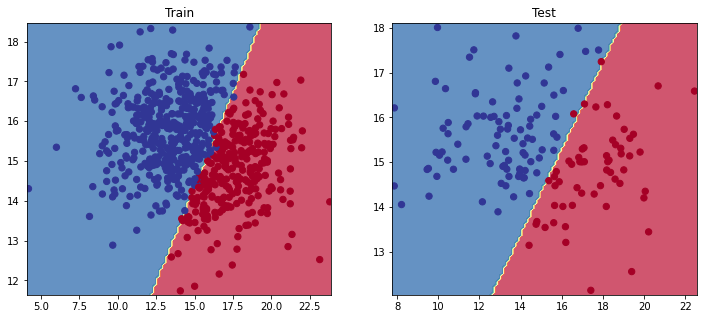

In [98]:
# Visualise the decision boundary 

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model = model, X = X_train, y = y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model = model, X = X_test, y = y_test)
plt.show()